# Comparison of Techniques for mapping streams

The Inviscid Burgers equation
$$
\frac{\partial u}{\partial t} + u\frac{ \partial u}{\partial x}=0
$$

The Cauchy problem is defined by this equation on the domain $ -\infty < x < \infty$, $t \geq 0$, together with initial condition 
$$
u(x, 0) = F(x)
$$ 

The inviscid Burgers equation is the simplest model that includes nonlinearity and viscous effects of fluids. 
# The HUX underlying PDE

$$
\frac{\partial v_{r}}{\partial \phi}  -\frac{1}{\Omega_{rot}}v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

The Cauchy problem is defined by the equation above on the domain $ 0 < r < \infty$, $0 \leq \phi \leq 2 \pi$, where $\Omega_{rot}$ is the angular frequency of the Sun's rotation, equal to $2 \pi / 25.38 \text{ days}$ at the solar equator. The initial condition is
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

In order to propagate Parker Solar Probe (PSP) solar wind velocity observations to OMNI (Earth). The initial condition will vary in $\phi$ and $r$ such that 

$$
v_{r}(\phi, r_{0}) = v_{r_{0}} \\
r_{0} = [r_{0}, r_{1}, ... r_{N}]^{T}
$$

Where $r_{0}$ is non-uniform since PSP varies in radial distance from the Sun in Heliographic (rotating) Coordinate System (HG). 

# Finite Difference solution (HUX-f/b)


The HUX-f technique leverages the forward finite difference approximation (upwind scheme), such that
$$
-\Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


<!-- $$
v_{i+1, j}\frac{v_{i, j}}{\Delta r} - \frac{v_{i, j}^2}{\Delta r} 
= \Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi}
$$


$$
v_{i+1, j}\frac{v_{i, j}}{\Delta r}
= \Omega_{rot} \frac{v_{i, j+1}}{\Delta \phi} - \Omega_{rot}\frac{v_{i, j}}{\Delta \phi} +  \frac{v_{i, j}^2}{\Delta r} 
$$


$$
v_{i+1, j}
= \frac{\Delta r}{v_{i, j}}(\Omega_{rot} \frac{v_{i, j+1}}{\Delta \phi} - \Omega_{rot}\frac{v_{i, j}}{\Delta \phi} +  \frac{v_{i, j}^2}{\Delta r})
$$
 -->
$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{\Delta \phi}  (\frac{v_{i, j+1} - v_{i, j}}{v_{i, j}})
$$

Whereas HUX-b technique leverages the backwards finite difference approximation, such that 

$$
-\Omega_{rot} \frac{v_{i, j} - v_{i, j-1}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i, j} - v_{i-1, j}}{\Delta r}) = 0
$$


$$
v_{i-1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{\Delta \phi}  (v_{i, j}-\frac{v_{i, j-1}}{v_{i, j}})
$$

where for simplicity the $r$ subscipt on the radial velocity is ommitted. The indicies $i$ and $j$ refer to $r$ and $\phi$ grids repectively. 

## Method of Characteristics
The method fo charateristics can be applied to quasilinear partial differential equations (PDEs) of the form 
$$
\frac{\partial \rho}{\partial t} + c \frac{\partial \rho}{\partial x} = Q
$$
where $c$ and $Q$ may be functions of $x$, $t$, and $\rho$. 
By the method of characteristics, we obtain that 
$$
\frac{\partial \rho}{\partial t} = Q
$$
if 
$$
\frac{\partial x}{\partial t} = c
$$

Hence, the PDE reduces to two coupled oridnary differential equations. The characteristics may be otained by integrating the equation above. 

In our application of the traveling wave, the characteristics are as follows

$$
\frac{\partial v}{\partial \phi} = 0
$$
if 
$$
\frac{\partial r}{\partial \phi} = -\frac{1}{\Omega_{rot}}v_{r}
$$

Resulting in 

$$
\Delta \phi = -\frac{\Omega_{rot} (\Delta r)}{v_{r}}
$$

this approximation is called the ballistic approximation for mapping solar wind streams to different locations in the heliosphere. It assumes that each parcel of plasma continues at a constant speed $v_{r}$ through out the heliosphere [1, Riley et al.].

If the initial velocity is smooth, then the ballistic approximation can be used to determine the solution for small enough $\Delta r$ where the characteristics do not cross. The following section about shock waves will illustrate the numerical and analytic difficulties.

# Shock waves

For quasilinear PDEs, it is quite usual for characteristics to intersect. This phenomena occurs when faster parcels catch up to the slower. As we move in the Heliosphere, the radial distance between the two particles decreases. This is called a *compression wave*.

To visualize the characteristic lines, lets import an initial velocity profile from the MHD solutions


In [1]:
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import numpy as np 
import matplotlib.pyplot as plt
from hux_propagation import *
import astropy.units as u
%matplotlib notebook

In [2]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr="2210")

model = MASOutput(mas_path)

print(model.variables)

['br', 'rho', 'vr']


In [3]:
# read in MHD velocity results. 
vr_model = model['vr']

In [4]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = vr_model.r_coords*(695700)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [5]:
v_at_30_radii_equator = np.array(f[:, 55, 0])
v_at_1_au_equator = np.array(f[:, 55, -1])

<IPython.core.display.Javascript object>


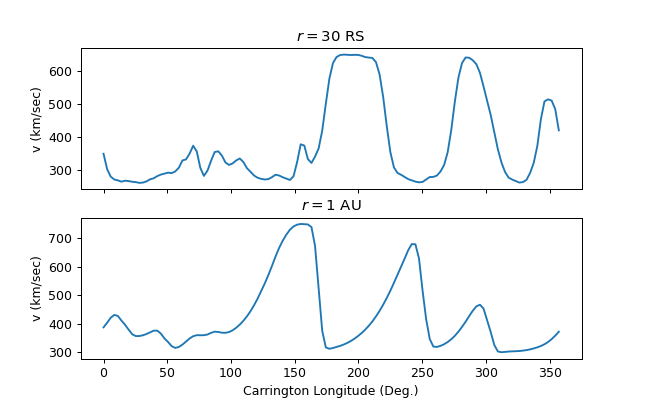

Text(0.5, 1.0, '$r = 1$ AU')

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (8,5), sharex=True)
ax[0].plot(p*(180/np.pi), v_at_30_radii_equator)
ax[0].set_ylabel("v (km/sec)")
ax[0].set_title("$r = 30$ RS")


ax[1].plot(p*(180/np.pi), v_at_1_au_equator)
ax[1].set_xlabel("Carrington Longitude (Deg.)")
ax[1].set_ylabel("v (km/sec)")
ax[1].set_title("$r = 1$ AU")

In [7]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

$$
\Delta \phi = -\frac{\Omega_{rot} (\Delta r)}{v_{r}}
$$

<IPython.core.display.Javascript object>


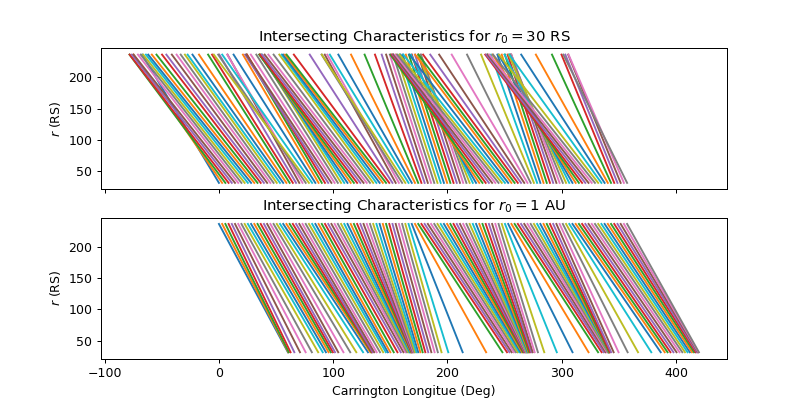

Text(0.5, 1.0, 'Intersecting Characteristics for $r_{0} = 1$ AU')

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,5), sharex=True)

jj = 0
for ii in p:
    ax[0].plot((ii - omega_rot*(dr)/(v_at_30_radii_equator[jj])*np.arange(r[1:].shape[0]))*(180/np.pi)
            , r[1:]/(695700))
    jj+=1
#ax[0].set_xlabel("Carrington Longitue (Deg)")
ax[0].set_ylabel("$r$ (RS)")
ax[0].set_title("Intersecting Characteristics for $r_{0} = 30$ RS")



jj = 0
for ii in p:
    ax[1].plot((ii - omega_rot*(-dr)/(v_at_1_au_equator[jj])*np.arange(r[1:].shape[0]))*(180/np.pi)
            , r[1:][::-1]/(695700))
    jj+=1
ax[1].set_xlabel("Carrington Longitue (Deg)")
ax[1].set_ylabel("$r$ (RS)")
ax[1].set_title("Intersecting Characteristics for $r_{0} = 1$ AU")

<IPython.core.display.Javascript object>


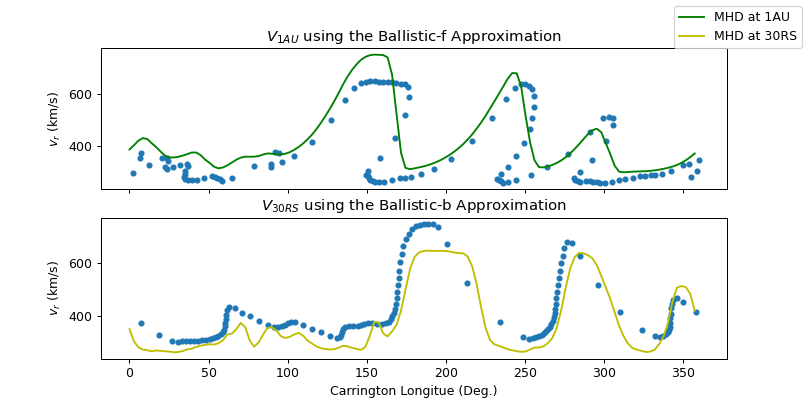

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,5), sharex=True)

phi_shift = -omega_rot*(-r[0] +r[-1])/v_at_30_radii_equator
ax[0].scatter(((p + phi_shift) %(2*np.pi))*(180/np.pi), v_at_30_radii_equator, s=15)
ax[0].plot(p*(180/np.pi), v_at_1_au_equator, c="g", label="MHD at 1AU")
ax[0].set_ylabel("$v_{r}$ (km/s)")
ax[0].set_title("$V_{1AU}$ using the Ballistic-f Approximation")


phi_shift = -omega_rot*(-r[-1] + r[0])/v_at_1_au_equator
ax[1].scatter(((p + phi_shift) %(2*np.pi))*(180/np.pi), v_at_1_au_equator, s=15)

ax[1].plot(p*(180/np.pi), v_at_30_radii_equator, c="y", label="MHD at 30RS")

ax[1].set_xlabel("Carrington Longitue (Deg.)")
ax[1].set_ylabel("$v_{r}$ (km/s)")
ax[1].set_title("$V_{30RS}$ using the Ballistic-b Approximation")
fig.legend()

Notice that the method of characteristics predicts the velocity becomes a **multivalued** function of carrington longitude. Meaning, at some location in longitude there are three velocities, as illustrated above. Hence, the velocity wave *breaks*. In some applications, a multivalued solutions is possible, such as breaking waves on a sloping beach. However, in our application, having three values of velocity at one place makes no sense, therefore the velocity function must be a single valued function of carrington longitude.

* **Proposition** If the initial propagation velocity of the solar wind is an increasing function of ($\phi$), then the velocity wave eventually "breaks" and becomes a multi-valued solution. 

* **Proof** Suppose that that $\phi_{1}$, $\phi_{2}$ are two points in Carrignton longitude ($\phi \in [0, 2\pi]$), where $\phi_{1} < \phi_{2}$ and $v_{\phi_{1}} < v_{\phi_{2}}$ where obviously $(v_{\phi_{2}}, v_{\phi_{2}} >0)$. Then, $$\frac{\Omega_{rot}}{v_{\phi_{1}}} > \frac{\Omega_{rot}}{v_{\phi_{2}}}$$ leading to $$-\frac{\Omega_{rot}}{v_{\phi_{1}}} <-\frac{\Omega_{rot}}{v_{\phi_{2}}}$$ where $\Omega_{rot}$ is the angular frequency of the Sun's rotation, equal to $\frac{2 \pi}{25.38} \text{ 1/ days}$ at the solar equator.  
Therefore, the characteristic emanating from $(\phi_{1}, r_{0})$ and $(\phi_{2}, r_{0})$ will intersect at some point $(\tilde \phi, \tilde r)$. After the intersection, the propogated wave becomes multivalued and "breaks".


The domain of dependence when solving the equation using the characteristic lines is a single point. Meaning, if we change the initial data at any point other than $\phi_{0}$ the solution $v_{r}(\phi_{0}, r)$ remains the same.

<IPython.core.display.Javascript object>


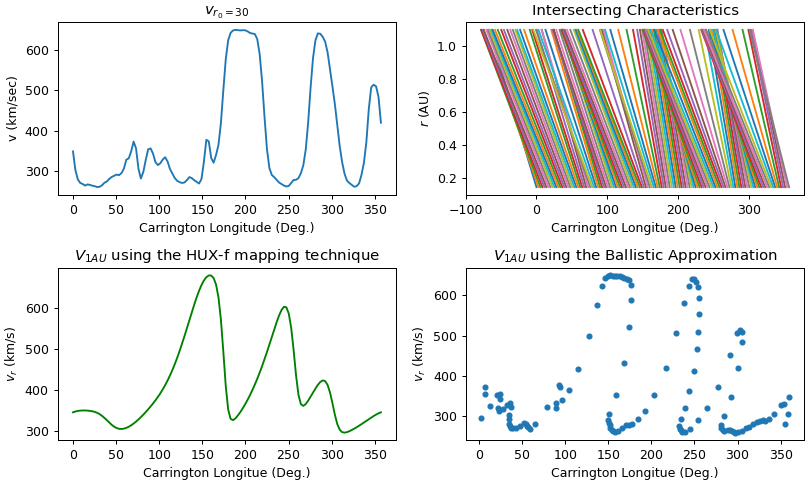

Text(0.5, 1.0, '$V_{1AU}$ using the HUX-f mapping technique')

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True,figsize=(10, 6))
ax[0][0].plot(p*(180/np.pi), v_at_30_radii_equator)
ax[0][0].set_xlabel("Carrington Longitude (Deg.)")
ax[0][0].set_ylabel("v (km/sec)")
ax[0][0].set_title("$v_{r_{0}=30}$")


jj = 0
for ii in p:
    ax[0][1].plot((ii - omega_rot*(dr)/(v_at_30_radii_equator[jj])*np.arange(r[1:].shape[0]))*(180/np.pi)
            , r[1:]/(695700*215.032))
    jj+=1
ax[0][1].set_xlabel("Carrington Longitue (Deg.)")
ax[0][1].set_ylabel("$r$ (AU)")
ax[0][1].set_title("Intersecting Characteristics")

phi_shift = apply_ballistic_approximation(np.array(v_at_30_radii_equator), 
                r[-1] - r[0], p)*180/np.pi
ax[1][1].scatter(phi_shift, v_at_30_radii_equator, s=15)
ax[1][1].set_xlabel("Carrington Longitue (Deg.)")
ax[1][1].set_ylabel("$v_{r}$ (km/s)")
ax[1][1].set_title("$V_{1AU}$ using the Ballistic Approximation")


ax[1][0].plot(p*180/np.pi, apply_forward_upwind_model(v_at_30_radii_equator, dr, p[1:] -p[:-1]),
            'g',label="HUX-f Technique")

ax[1][0].set_xlabel("Carrington Longitue (Deg.)")
ax[1][0].set_ylabel("$v_{r}$ (km/s)")
ax[1][0].set_title("$V_{1AU}$ using the HUX-f mapping technique")

<IPython.core.display.Javascript object>


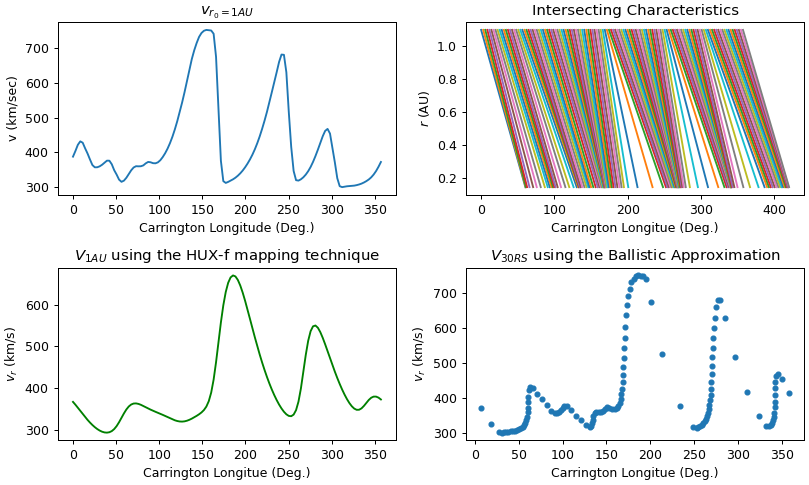

Text(0.5, 1.0, '$V_{1AU}$ using the HUX-f mapping technique')

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True,figsize=(10, 6))
ax[0][0].plot(p*(180/np.pi), v_at_1_au_equator)
ax[0][0].set_xlabel("Carrington Longitude (Deg.)")
ax[0][0].set_ylabel("v (km/sec)")
ax[0][0].set_title("$v_{r_{0}=1AU}$")


jj = 0
for ii in p:
    ax[0][1].plot((ii - omega_rot*(-dr)/(v_at_1_au_equator[jj])*np.arange(r[1:].shape[0]))*(180/np.pi)
            , r[1:][::-1]/(695700*215.032))
    jj+=1
ax[0][1].set_xlabel("Carrington Longitue (Deg.)")
ax[0][1].set_ylabel("$r$ (AU)")
ax[0][1].set_title("Intersecting Characteristics")


phi_shift = apply_ballistic_approximation(np.array(v_at_1_au_equator), 
                -r[-1] + r[0], p)*180/np.pi
ax[1][1].scatter(phi_shift, v_at_1_au_equator, s=15)
ax[1][1].set_xlabel("Carrington Longitue (Deg.)")
ax[1][1].set_ylabel("$v_{r}$ (km/s)")
ax[1][1].set_title("$V_{30RS}$ using the Ballistic Approximation")


ax[1][0].plot(p*180/np.pi, apply_backwards_upwind_model(v_at_1_au_equator, dr, p[1:] -p[:-1]),
            'g',label="HUX-f Technique")

ax[1][0].set_xlabel("Carrington Longitue (Deg.)")
ax[1][0].set_ylabel("$v_{r}$ (km/s)")
ax[1][0].set_title("$V_{1AU}$ using the HUX-f mapping technique")

#### When can we use the method of characteristics to approximate $v_{r}$?
For a small enough $\Delta r$, a solution can be constructed by following the characteristic lines. As long as the characteristic lines do not cross, we can approximate the solution using such assumtion. 

## Upwind Method

The first order upwind method has a one-sided stencil. The upwind method results in physical solutions meaning it forces the $v_{r}(\phi)$ solution at any given $r$ to be a single-valued function. The first order upwind method can result in smeared solutions at discontinuities and severe numerical diffusion/dissipation.



### Upwind second order approximation 
$$
-\Omega_{rot} \frac{-3v_{i, j} + 4v_{i, j+1} - v_{i, j+2}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{\Delta \phi}  (\frac{-3v_{i, j} + 4v_{i, j+1} - v_{i, j+2}}{v_{i, j}})
$$



<IPython.core.display.Javascript object>


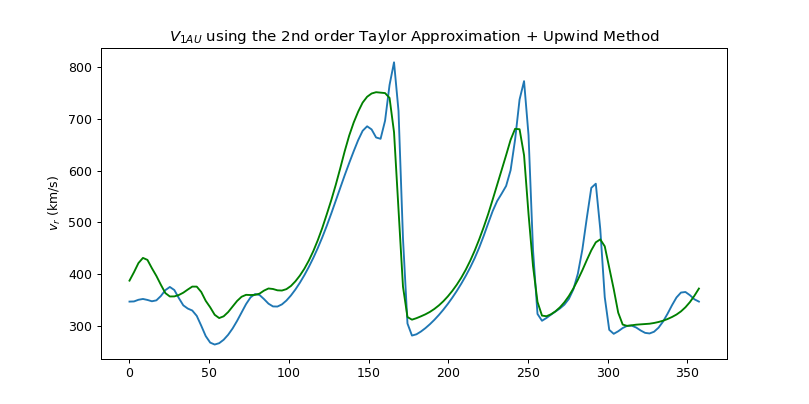

Text(0.5, 1.0, '$V_{1AU}$ using the 2nd order Taylor Approximation + Upwind Method')

In [12]:
fig, ax = plt.subplots( figsize = (10,5), sharex=True)


ax.plot((p)*(180/np.pi), apply_second_order_f_upwind(v_at_30_radii_equator, dr, p[1:] -p[:-1])[-1, :])
ax.plot(p*(180/np.pi), v_at_1_au_equator, c="g", label="MHD at 1AU")
ax.set_ylabel("$v_{r}$ (km/s)")
ax.set_title("$V_{1AU}$ using the 2nd order Taylor Approximation + Upwind Method")



In [13]:
apply_second_order_f_upwind(v_at_30_radii_equator, dr, p[1:] -p[:-1]).shape

(140, 128)

## 